En este notebook voy a intentar resumir el trabajo que he hecho sobre la predicción del movimiento de un péndulo doble con las técnicas propias de la predicción de series temporales (modelo ARMA, ARIMA, VAR) y el uso de modelos de redes neuronales artificiales (ANN), así como la comparación entre estos diferentes métodos, con breves explicaciones de cada cosa.

Evidentemente, mi falta de conocimientos de series temporales y de redes neuronales han hecho que este trabajo terminase llevando mucho más tiempo del que pensaba que me iba a llevar, además de terminar sin un objetivo del todo definido más que el de aprender, pero creo que merece la pena dejarlo bien documentado y presentado para una futura revisión cuando ya tenga un mayor bagaje en esto de la estadística y la ciencia de datos. Además de que se ha visto que este tema es muy interesante y hay mucho trabajo hecho, y merece la pena pararse y ponerse a mirar bien qué se ha hecho hasta ahora para luego hacer más cosas.

Se ha podido hacer:

PONER AQUI LO QUE SE HA HEHCO EN CUANTO SE TERMINE EL NOTEBOOK 

Y, a mi juicio, queda por hacer:



*   Del análisis exploratorio de la serie temporal: en el análisis espectral, ver la diferencia de máximos entre cada espectro de cada método de predicción. Ver para qué nos sirve el espectro de la serie temporal de cada método de predicción. Descomponer en estacionariedad, trend y residuos con los modelos multiplicativos o con el modelo aditivo. Hacer el QQplot y el probability plot de la serie temporal, y ver su utilidad.

*   Ver un poco también en qué consiste la descomposición de la serie espectral.


*   Interpretar el test de estacionariedad que se ha hecho.

*   Buscar los valores de p, d, q mejores con el criterio AIC para el modelo ARIMA.

*   Informarse sobre el modelo Prophet de Facebook para la predicción de series temporales e implementarlo en la predicción.

*   Probar a usar el Monte-Carlo dropout para el entrenamiento de la serie temporal.


*   Hay que informarse de otras cosas: Periodograma vs Welch. Usar el TensorBoard. Restricted Boltzmann Machine ó autoencoders. Modelo VAR: ¿por qué es tan bueno? ¿cómo funciona la función en la librería de Python?


En la carpeta de los proyectos tenemos lo siguiente DESCRIBIR UN POCO COMO ESTÁ ORGANIZADO EL PROYECTO, AUNQUE CONVENDRÍA HACER UN ESQUEMITA.

El problema consiste en lo siguiente:

1.   Generamos un dataset resolviendo la ecuación diferencial m veces, de manera que tenemos un dataset que a veces pueda ser bastante tocho.
2.   Entrenamos el modelo de red neuronal (antes definido) con ese dataset.
3. Volvemos a resolver el sistema de ecuaciones diferenciales una vez para obtener el dataset con el cual vamos a hacer predicciones.
4. Separamos el dataset por la mitad y, con la primera mitad vamos a generar una segunda mitad, haciendo que nuestro modelo prediga la serie temporal, y vamos a unirlo con la primera mitad. De esta manera, tenemos tantos datasets finales como métodos de predicción hemos usado. Dichos métodos son:

  *   ARMA
  *   ARIMA
  *   Red neuronal artificial
  *   VAR 

5. Por último, se han explorado todos los datasets de diferentes maneras, sacando varias cosas y gráficos:

*   Gráfica de $\theta_{i} - t$ con i = 1, 2.
*   Gráfica de $\theta_1 - \theta_2$.
*   Errores de $\theta_{i}^{pred}$ frente a $\theta_{i}^{real}$ con i = 1, 2.
*   Gráfica de $\omega_{i} - t$ con i = 1, 2. (en el caso de que se use el modelo con velocidades).
*   Gráfica de $\omega_1 - \omega_2$. (en el caso de que se use el modelo con velocidades).
*   Errores de $\omega_{i}^{pred}$ frente a $\omega_{i}^{real}$ con i = 1, 2. (en el caso de que se use el modelo con velocidades).
*   Gráfica de la energía cinética, energía potencial, y energía total.
*   Espectro de frecuencias (Tanto periodogramas como Welch).
*   Animaciones del péndulo para cada método de predicción.
*   Gráfico de la media móvil respecto del tiempo.
*   Gráfico de la autocovarianza respecto del tiempo.
*   Test de estacionariedad de las series temporales.


También hay que decir que se han probado tres formas de entrenar la red neuronal:

1. Se generan m sistemas dinámicos (a partir de generar aleatoriamente m condiciones iniciales y resolver el sistema de ecuaciones diferenciales), se agrupan todas las soluciones en un dataset muy grande y se pasan a la red neuronal. Este es el que más se ha probado.

2. Se genera un sólo sistema dinámico muy grande (a partir de una condición inicial) y se pasa sólo el dataset generado a partir de este. No ha resultado muy bien este método.

3. Se generan m sistemas dinámicos (a partir de generar m condiciones iniciales y resolver el sistema de ecuaciones diferenciales), y se pasa el dataset resultante de UN solo sistema dinámico a la red, y se entrena a esta con dicho sistema, y así se le pasan todos los sitemas.


En todos los casos, antes de pasar el dataset, este se ha separado en un conjunto de entrenamiento y en un conjunto de test. En el conjunto de entrenamiento, se ha pasado el conjunto dataset[0:n-1] como features y el conjunto dataset[1:n] como etiquetas, siendo n la dimensión del dataset original. Esto es para que el modelo de ANN aprenda viendo un punto y su punto siguiente.






In [9]:
# importamos los módulos comunes a todos los modelos
import numpy as np # manejo de arrays
from numpy import sin, cos # se pone directamente para no tener que poner el np después de cada seno y coseno
import pandas as pd # para el manejo de datos
import matplotlib.pyplot as plt # para las representaciones de gráficas
import scipy.integrate as integrate # para la resolución de sistemas de ecuaciones diferenciales
from collections import deque # 
from statsmodels.tsa.arima.model import ARIMA # importamos el modelo ARIMA
from statsmodels.tsa.vector_ar.var_model import VAR # modelo VAR 
from scipy import signal # para la obtención y manejo del espectro de frecuencias
import statsmodels.tsa.api as smt # 
from statsmodels.tsa.stattools import adfuller # test de estacionariedad de dickey-fuller
import tensorflow.keras as keras # para el entrenamiento y definición de ANN's, aunque es posible que no sea necesario usarlo
from tensorflow.keras.layers import Dense, Dropout, Activation # Para las ANN's
from tensorflow.keras.models import Model, Sequential 
from tensorflow.keras.optimizers import Adam

Se ha probado a predecir el movimiento del péndulo tanto usando las velocidades angulares como no usándolas, así que se va a presentar el análisis exploratorio para cada modelo.

# Modelo sin las velocidades

In [10]:
# importamos los módulos propios de este modelo
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [11]:
import sys # Esta libreria nos permite acceder a una serie de variables usadas y mantenidas por el intérprete de Python y a 
# funciones que sólo interaccionan con este.
sys.path.append('/content/gdrive/MyDrive/Proyectos/Péndulo_doble(Prediccion)/Proyecto_bueno (sin velocidades)')
from Functions import separar_set, arima_univariant, var_multi, var_paso, crear_ANN, ANN_paso, ANN_multipaso, cuadratic_error, error
from Functions import CalcularVelocidad, CalcularECinetica, CalcularEPotencial, T_maximas
from Functions import arma_univariant, test_estacionariedad
from Pendulum import derivs


## 1.Obtención dataset

Antes de nada, obtenemos el dataset de resolver el sistema de ecuaciones diferenciales con unas condiciones inciales random.

In [12]:
# Parámetros para resolver el problema (no los vamos a usar, pero se indican aqui)
G = 9.8  # acceleration due to gravity, in m/s^2
L1 = 1.0  # length of pendulum 1 in m
L2 = 1.0  # length of pendulum 2 in m
L = L1 + L2  # maximal length of the combined pendulum
M1 = 1.0  # mass of pendulum 1 in kg
M2 = 1.0  # mass of pendulum 2 in kg
t_stop = 10 # how many seconds to simulate
dt = 0.02 # El salto temporal
t = np.arange(0, t_stop, dt)

# Condiciones iniciales (en un principio en grados)
th1 = -100.0 # Angulo inicial de la particula 1
w1 = 30.0 # Velocidad angular inicial de la particula 1
th2 = -50.0 # Velocidad angular inicial de la particula 2
w2 = 0.0 # ANgulo inicial de la particula 2
state = np.radians([th1, w1, th2, w2])

# Resolvemos el sistema con los parametros
y = integrate.odeint(derivs, state, t)
datos = pd.DataFrame({'x1(Ang1)': y[:, 0], 'x2(Vel1)': y[:, 1], 'x3(Ang2)': y[:, 2], 'x4(Vel2)': y[:, 3]})

In [13]:
l = [4, 5, 6, 8, 3, 40]
l[:-1]

[4, 5, 6, 8, 3]

# Modelo con las velocidades

## 1. Obtención del dataset

Antes de nada, obtenemos el dataset de resolver el sistema de ecuaciones diferenciales con unas condiciones inciales random.

In [14]:
# importamos los módulos propios de este modelo
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [15]:
# importamos los módulos propios de este modelo
import sys # Esta libreria nos permite acceder a una serie de variables usadas y mantenidas por el intérprete de Python y a 
# funciones que sólo interaccionan con este.
sys.path.append('/content/gdrive/MyDrive/Proyectos/Péndulo_doble(Prediccion)/Proyecto_bueno')
from Functions import separar_set, arima_univariant, var_multi, var_paso, crear_ANN, ANN_paso, ANN_multipaso, cuadratic_error, error
from Functions import CalcularVelocidad, CalcularECinetica, CalcularEPotencial, T_maximas
from Functions import arma_univariant, test_estacionariedad
from Pendulum import derivs

In [18]:
# Parámetros para resolver el problema (no los vamos a usar, pero se indican aqui)
G = 9.8  # acceleration due to gravity, in m/s^2
L1 = 1.0  # length of pendulum 1 in m
L2 = 1.0  # length of pendulum 2 in m
L = L1 + L2  # maximal length of the combined pendulum
M1 = 1.0  # mass of pendulum 1 in kg
M2 = 1.0  # mass of pendulum 2 in kg
t_stop = 10 # how many seconds to simulate
dt = 0.02 # El salto temporal
t = np.arange(0, t_stop, dt)

# Condiciones iniciales (en un principio en grados)
th1 = -100.0 # Angulo inicial de la particula 1
w1 = 30.0 # Velocidad angular inicial de la particula 1
th2 = -50.0 # Velocidad angular inicial de la particula 2
w2 = 0.0 # ANgulo inicial de la particula 2
state = np.radians([th1, w1, th2, w2])

# Resolvemos el sistema con los parametros
y = integrate.odeint(derivs, state, t)
datos = pd.DataFrame({'x1(Ang1)': y[:, 0], 'x2(Vel1)': y[:, 1], 'x3(Ang2)': y[:, 2], 'x4(Vel2)': y[:, 3]})


## 2. Predicción con cada método

### 1. Serie temporal

Obtenemos las predicciones ya unidas a la primera mitad, y representamos la serie temporal.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


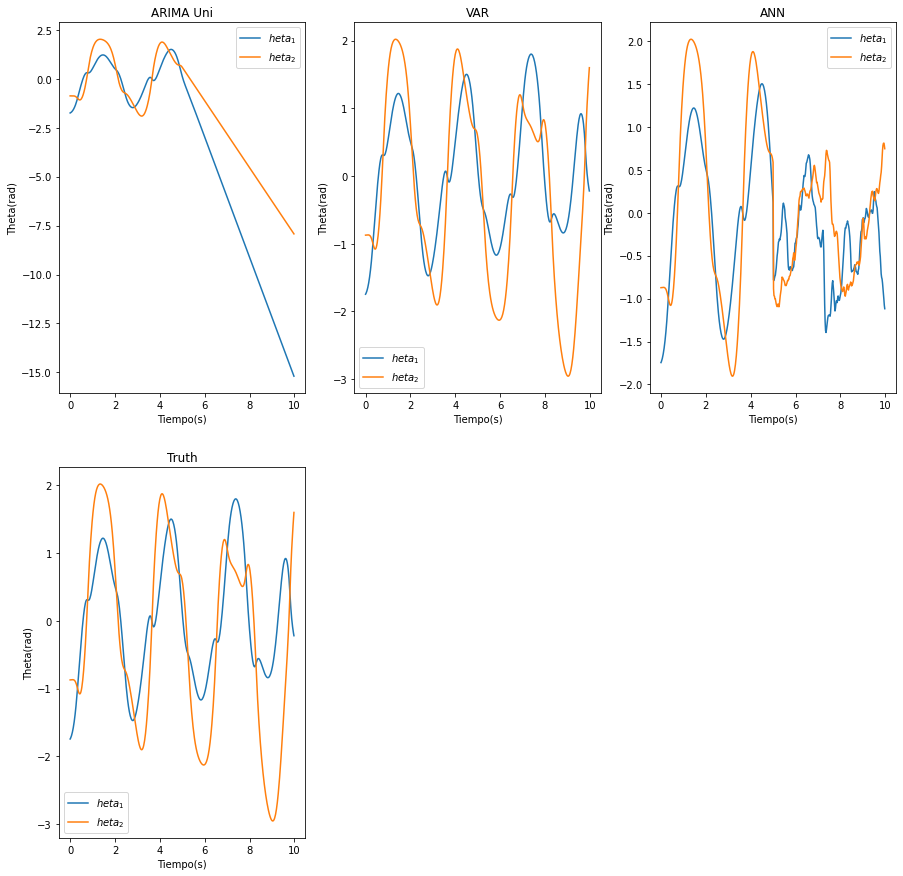

In [20]:
# separamos el dataset por la mitad, esto realmente es algo que ya hacen todos los métodos de predicción en sus funciones de forma automatica
r = 0.5 # Proporción en la que queremos separar el dataset
n = len(y) # Hay que indicar también el tamaño del dataset

# importamos el modelo de red neuronal y predecimos
model_ANN = keras.models.load_model('/content/gdrive/MyDrive/Proyectos/Péndulo_doble(Prediccion)/Proyecto_bueno/modelo_definitivo6.h5')
y_ANN = ANN_multipaso(model_ANN, datos.values)
datos_ANN = pd.DataFrame({'x1(Ang1)': y_ANN[:, 0], 'x2(Vel1)': y_ANN[:, 1],'x3(Ang2)': y_ANN[:, 2], 'x4(Vel2)': y_ANN[:, 3]})

# usamos el método ARIMA
p1, d1, q1 = 2, 2, 1
theta1_arima = arima_univariant(datos.values[:, 0], p1, d1, q1)
p2, d2, q2 = 2, 2, 1
omega1_arima = arima_univariant(datos.values[:, 1], p2, d2, q2)
p3, d3, q3 = 0, 2, 0
theta2_arima = arima_univariant(datos.values[:, 2], p3, d3, q3)
p4, d4, q4 = 1, 2, 2
omega2_arima = arima_univariant(datos.values[:, 3], p4, d4, q4)
datos_arima = pd.DataFrame({'x1(Ang1)': theta1_arima, 'x2(Vel1)': omega1_arima, 'x3(Ang2)': theta2_arima, 'x4(Vel2)': omega2_arima})

# usamos el método VAR
y_var_multi = var_multi(datos.values)
datos_var = pd.DataFrame({'x1(Ang1)': y_var_multi[:, 0], 'x2(Vel1)': y_var_multi[:, 1], 'x3(Ang2)': y_var_multi[:, 2], 'x4(Vel2)': y_var_multi[:, 3]})

# usamos el método ARMA
"""y_ARMA = np.empty_like(y_var_multi)
for i in range(4):
  y_ARMA[:, i] = arma_univariant(datos.values[:, i])
datos_arima = pd.DataFrame({'x1(Ang1)': y_ARMA[:, 0], 'x2(Vel1)': y_ARMA[:, 1], 'x3(Ang2)': y_ARMA[:, 2], 'x4(Vel2)': y_ARMA[:, 3]}) """

#theta1_arma = arma_univariant(datos.values[:, i])

""" Ploteamos las series temporales de los ángulos y las velocidades para cada método de predicción """

fig1_series = plt.figure(figsize=(15, 15))
for i in range(4):
    ax1_series = fig1_series.add_subplot(2, 3, i+1)
    ax1_series.set_title("Grafico #%i"%int(i+1))
fig1_series.subplots_adjust(wspace = 0.2, hspace = 0.2)

# ARIMA univariante
fig1_series.axes[0].plot(t, datos_arima.values[:len(t), 0], label = "$\theta_1$")
fig1_series.axes[0].plot(t, datos_arima.values[:len(t), 2], label = "$\theta_2$")
fig1_series.axes[0].set_xlabel("Tiempo(s)")
fig1_series.axes[0].set_ylabel("Theta(rad)")
fig1_series.axes[0].set_title("ARIMA Uni")
fig1_series.axes[0].legend()

# VAR multistep
fig1_series.axes[1].plot(t, datos_var.values[:len(t), 0], label = "$\theta_1$")
fig1_series.axes[1].plot(t, datos_var.values[:len(t), 2], label = "$\theta_2$")
fig1_series.axes[1].set_title("VAR")
fig1_series.axes[1].set_xlabel("Tiempo(s)")
fig1_series.axes[1].set_ylabel("Theta(rad)")
fig1_series.axes[1].legend()

# ANN multistep
fig1_series.axes[2].plot(t, datos_ANN.values[:len(t), 0], label = "$\theta_1$")
fig1_series.axes[2].plot(t, datos_ANN.values[:len(t), 2], label = "$\theta_2$")
fig1_series.axes[2].set_title("ANN")
fig1_series.axes[2].set_xlabel("Tiempo(s)")
fig1_series.axes[2].set_ylabel("Theta(rad)")
fig1_series.axes[2].legend()

# Truth
fig1_series.axes[3].plot(t, datos.values[:len(t), 0], label = "$\theta_1$")
fig1_series.axes[3].plot(t, datos.values[:len(t), 2], label = "$\theta_2$")
fig1_series.axes[3].set_title("Truth")
fig1_series.axes[3].set_xlabel("Tiempo(s)")
fig1_series.axes[3].set_ylabel("Theta(rad)")
fig1_series.axes[3].legend()

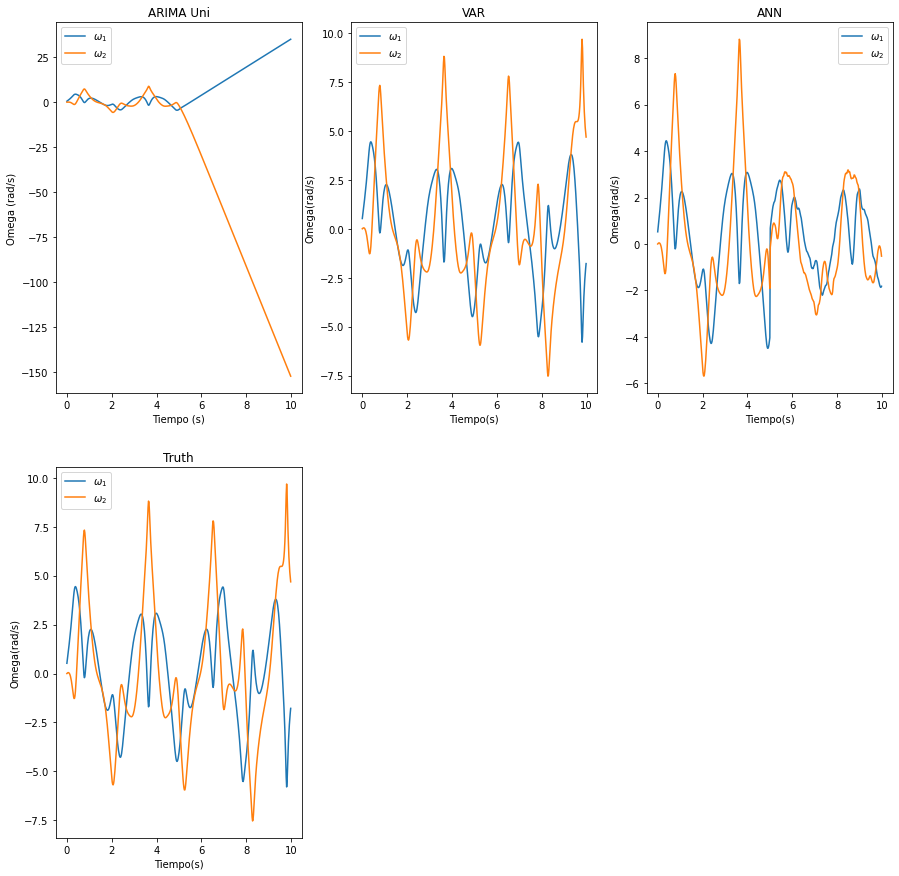

In [22]:
""" Ploteamos las velocidades """
fig1_vel = plt.figure(figsize=(15, 15))
for i in range(4):
    ax1_vel = fig1_vel.add_subplot(2, 3, i+1)
    ax1_vel.set_title("Grafico #%i"%int(i+1))
fig1_series.subplots_adjust(wspace = 0.2, hspace = 0.2)

# ARIMA univariante
fig1_vel.axes[0].plot(t, datos_arima.values[:len(t), 1], label = "$\omega_1$")
fig1_vel.axes[0].plot(t, datos_arima.values[:len(t), 3], label = "$\omega_2$")
fig1_vel.axes[0].set_xlabel("Tiempo (s)")
fig1_vel.axes[0].set_ylabel("Omega (rad/s)")
fig1_vel.axes[0].set_title("ARIMA Uni")
fig1_vel.axes[0].legend()

# VAR multistep
fig1_vel.axes[1].plot(t, datos_var.values[:len(t), 1], label = "$\omega_1$")
fig1_vel.axes[1].plot(t, datos_var.values[:len(t), 3], label = "$\omega_2$")
fig1_vel.axes[1].set_title("VAR")
fig1_vel.axes[1].set_xlabel("Tiempo(s)")
fig1_vel.axes[1].set_ylabel("Omega(rad/s)")
fig1_vel.axes[1].legend()

# ANN multistep
fig1_vel.axes[2].plot(t, datos_ANN.values[:len(t), 1], label = "$\omega_1$")
fig1_vel.axes[2].plot(t, datos_ANN.values[:len(t), 3], label = "$\omega_2$")
fig1_vel.axes[2].set_title("ANN")
fig1_vel.axes[2].set_xlabel("Tiempo(s)")
fig1_vel.axes[2].set_ylabel("Omega(rad/s)")
fig1_vel.axes[2].legend()

# Truth
fig1_vel.axes[3].plot(t, datos.values[:len(t), 1], label = "$\omega_1$")
fig1_vel.axes[3].plot(t, datos.values[:len(t), 3], label = "$\omega_2$")
fig1_vel.axes[3].set_title("Truth")
fig1_vel.axes[3].set_xlabel("Tiempo(s)")
fig1_vel.axes[3].set_ylabel("Omega(rad/s)")
fig1_vel.axes[3].legend()

### 2. Errores

Esto es, sacar el error cuadrático medio

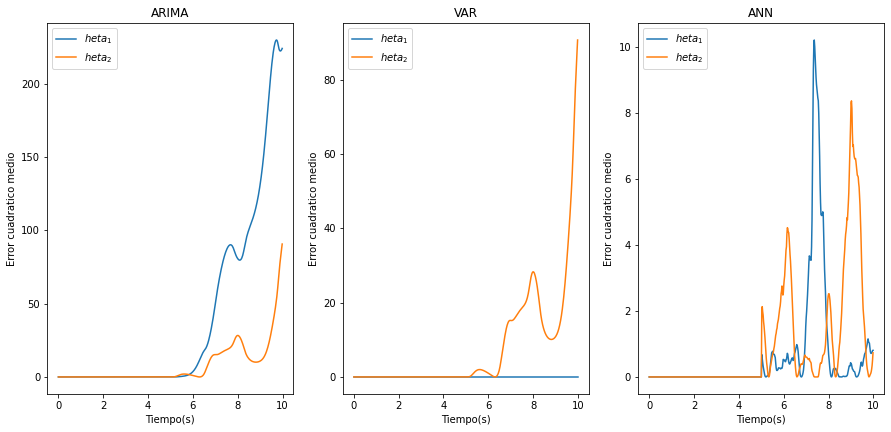

In [26]:
""" Obtenemos los errores """
# ARIMA
error_ARIMA = pd.DataFrame({'x1(Ang1)': error(datos_arima.values[:, 0], datos.values[:, 0]), 'x2(Vel1)': error(datos_arima.values[:, 1], datos.values[:, 1]), 'x3(Ang2)': error(datos_arima.values[:, 2], datos.values[:, 2]), 'x4(Vel2)': error(datos_arima.values[:, 3], datos.values[:, 3])})

# VAR
error_var = pd.DataFrame({'x1(Ang1)': error(datos_var.values[:, 0], datos.values[:, 0]), 'x2(Vel1)': error(datos_var.values[:, 1], datos.values[:, 1]), 'x3(Ang2)': error(datos_arima.values[:, 2], datos.values[:, 2]), 'x4(Vel2)': error(datos_arima.values[:, 3], datos.values[:, 3])})

# ANN
error_ANN = pd.DataFrame({'x1(Ang1)': error(datos_ANN.values[:, 0], datos.values[:, 0]), 'x2(Vel1)': error(datos_ANN.values[:, 1], datos.values[:, 1]), 'x3(Ang1)': error(datos_ANN.values[:, 2], datos.values[:, 2]), 'x4(Vel2)': error(datos_ANN.values[:, 3], datos.values[:, 3])})

""" Ploteamos los errores asociados a los angulos """
fig2_series = plt.figure(figsize=(15, 15))
for i in range(3):
    ax2_series = fig2_series.add_subplot(2, 3, i+1)
    ax2_series.set_title("Grafico #%i"%int(i+1))
fig2_series.subplots_adjust(wspace = 0.2, hspace = 0.2)

# ARIMA univariante
fig2_series.axes[0].plot(t, error_ARIMA.values[:, 0], label = "$\theta_1$")
fig2_series.axes[0].plot(t, error_ARIMA.values[:, 2], label = "$\theta_2$")
fig2_series.axes[0].set_title("ARIMA")
fig2_series.axes[0].set_xlabel("Tiempo(s)")
fig2_series.axes[0].set_ylabel("Error cuadratico medio")
fig2_series.axes[0].legend()

# VAR multistep
fig2_series.axes[1].plot(t, error_var.values[:, 0], label = "$\theta_1$")
fig2_series.axes[1].plot(t, error_var.values[:, 2], label = "$\theta_2$")
fig2_series.axes[1].set_title("VAR")
fig2_series.axes[1].set_xlabel("Tiempo(s)")
fig2_series.axes[1].set_ylabel("Error cuadratico medio")
fig2_series.axes[1].legend()

# ANN multistep
fig2_series.axes[2].plot(t, error_ANN.values[:, 0], label = "$\theta_1$")
fig2_series.axes[2].plot(t, error_ANN.values[:, 2], label = "$\theta_2$")
fig2_series.axes[2].set_title("ANN")
fig2_series.axes[2].set_xlabel("Tiempo(s)")
fig2_series.axes[2].set_ylabel("Error cuadratico medio")
fig2_series.axes[2].legend()


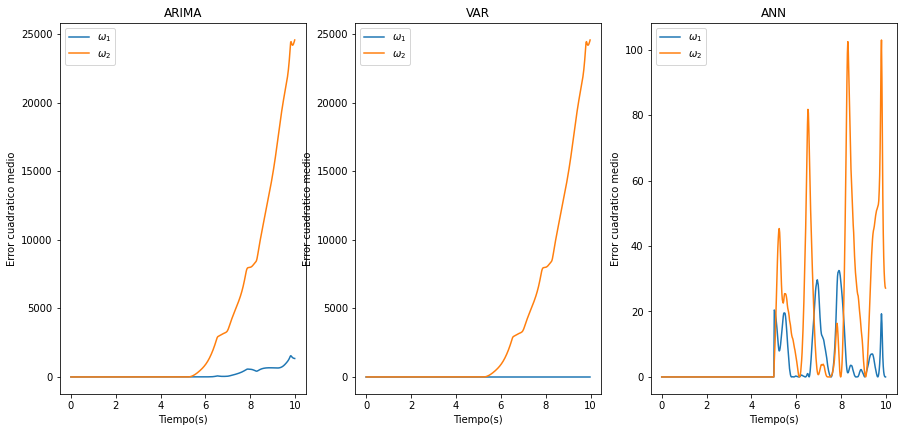

In [27]:
""" Ploteamos los errores asociados a las velocidades """
fig2_vel = plt.figure(figsize=(15, 15))
for i in range(3):
    ax2_vel = fig2_vel.add_subplot(2, 3, i+1)
    ax2_vel.set_title("Grafico #%i"%int(i+1))
fig2_vel.subplots_adjust(wspace = 0.2, hspace = 0.2)

# ARIMA univariante
fig2_vel.axes[0].plot(t, error_ARIMA.values[:, 1], label = "$\omega_1$")
fig2_vel.axes[0].plot(t, error_ARIMA.values[:, 3], label = "$\omega_2$")
fig2_vel.axes[0].set_title("ARIMA")
fig2_vel.axes[0].set_xlabel("Tiempo(s)")
fig2_vel.axes[0].set_ylabel("Error cuadratico medio")
fig2_vel.axes[0].legend()

# VAR multistep
fig2_vel.axes[1].plot(t, error_var.values[:, 1], label = "$\omega_1$")
fig2_vel.axes[1].plot(t, error_var.values[:, 3], label = "$\omega_2$")
fig2_vel.axes[1].set_title("VAR")
fig2_vel.axes[1].set_xlabel("Tiempo(s)")
fig2_vel.axes[1].set_ylabel("Error cuadratico medio")
fig2_vel.axes[1].legend()

# ANN multistep
fig2_vel.axes[2].plot(t, error_ANN.values[:, 1], label = "$\omega_1$")
fig2_vel.axes[2].plot(t, error_ANN.values[:, 3], label = "$\omega_2$")
fig2_vel.axes[2].set_title("ANN")
fig2_vel.axes[2].set_xlabel("Tiempo(s)")
fig2_vel.axes[2].set_ylabel("Error cuadratico medio")
fig2_vel.axes[2].legend()

### 3. Energías

Ahora, vamos a sacar las energías potencial, cinética y total para cada método de predicción. 

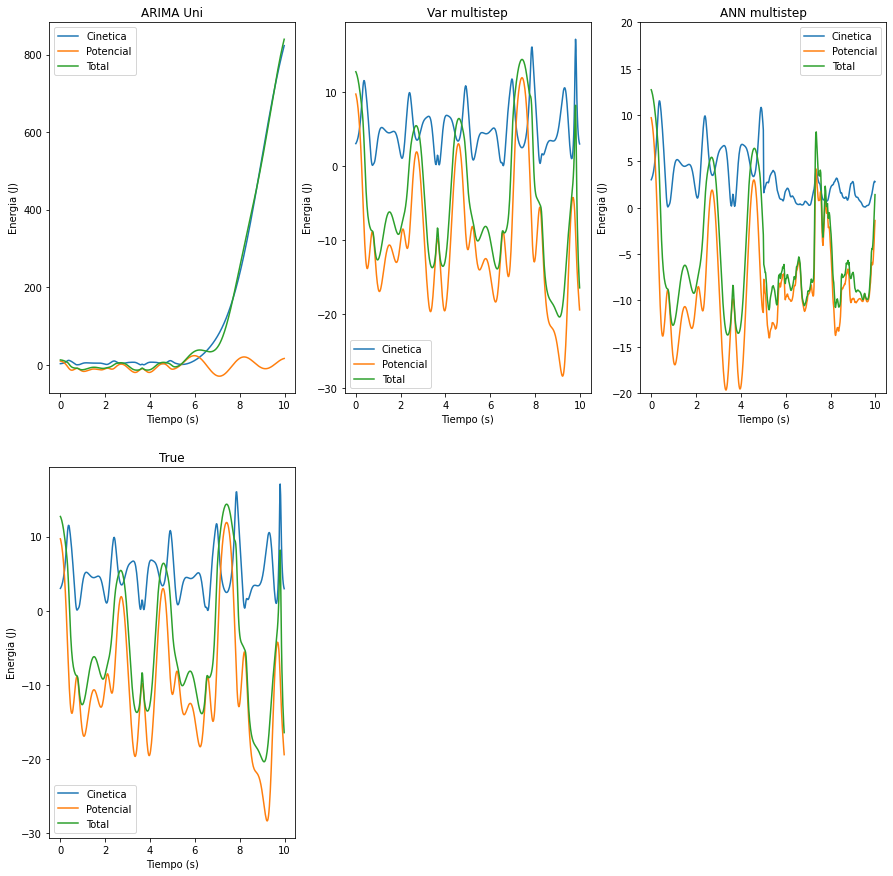

In [ ]:
""" Obtenemos las series temporales de las energías """
# ARIMA
K_arima, V_arima = CalcularECinetica(datos_arima.values[:, 0], datos_arima.values[:, 2], datos_arima.values[:, 1], datos_arima.values[:, 3], M1, M2, L1, L2, t), CalcularEPotencial(datos_arima.values[:, 0], datos_arima.values[:, 2] , datos_arima.values[:, 1], datos_arima.values[:, 3], M1, M2, L1, L2, t)

# VAR
K_var_multi, V_var_multi = CalcularECinetica(datos_var.values[:, 0], datos_var.values[:, 2], datos_var.values[:, 1], datos_var.values[:, 3], M1, M2, L1, L2, t), CalcularEPotencial(datos_var.values[:, 0], datos_var.values[:, 2], datos_var.values[:, 1], datos_var.values[:, 3], M1, M2, L1, L2, t)

#ANN
K_ANN_multi, V_ANN_multi = CalcularECinetica(datos_ANN.values[:, 0], datos_ANN.values[:, 2], datos_ANN.values[:, 1], datos_ANN.values[:, 3], M1, M2, L1, L2, t), CalcularEPotencial(datos_ANN.values[:, 0], datos_ANN.values[:, 2], datos_ANN.values[:, 1], datos_ANN.values[:, 3], M1, M2, L1, L2, t)

# True
K_true, V_true = CalcularECinetica(datos.values[:, 0], datos.values[:, 2], datos.values[:, 1], datos.values[:, 3], M1, M2, L1, L2, t), CalcularEPotencial(datos.values[:, 0], datos.values[:, 2], datos.values[:, 1], datos.values[:, 3], M1, M2, L1, L2, t)


""" Ploteamos """
fig3 = plt.figure(figsize=(15, 15))
for i in range(4):
    ax3 = fig3.add_subplot(2, 3, i+1)
    ax3.set_title("Grafico #%i"%int(i+1))
fig3.subplots_adjust(wspace = 0.2, hspace = 0.2)

# ARIMA univariante
fig3.axes[0].plot(t, K_arima[:len(t)], label = "Cinetica")
fig3.axes[0].plot(t, V_arima[:len(t)], label = "Potencial")
fig3.axes[0].plot(t, K_arima[:len(t)]+V_arima[:len(t)], label = "Total")
fig3.axes[0].set_title("ARIMA Uni")
fig3.axes[0].set_xlabel("Tiempo (s)")
fig3.axes[0].set_ylabel("Energia (J)")
fig3.axes[0].legend()

# VAR multi
fig3.axes[1].plot(t, K_var_multi[:len(t)], label = "Cinetica")
fig3.axes[1].plot(t, V_var_multi[:len(t)], label = "Potencial")
fig3.axes[1].plot(t[:len(K_arima)], K_var_multi[:len(t)]+V_var_multi[:len(t)], label = "Total")
fig3.axes[1].set_title("Var multistep")
fig3.axes[1].set_xlabel("Tiempo (s)")
fig3.axes[1].set_ylabel("Energia (J)")
fig3.axes[1].legend()

# ANN multipaso
fig3.axes[2].plot(t, K_ANN_multi[:len(t)], label = "Cinetica")
fig3.axes[2].plot(t, V_ANN_multi[:len(t)], label = "Potencial")
fig3.axes[2].plot(t, V_ANN_multi[:len(t)] + K_ANN_multi[:len(t)], label = "Total")
fig3.axes[2].set_ylim(-20.0, 20.0)
fig3.axes[2].set_title("ANN multistep")
fig3.axes[2].set_xlabel("Tiempo (s)")
fig3.axes[2].set_ylabel("Energia (J)")
fig3.axes[2].legend()

# Truth
fig3.axes[3].plot(t, K_true[:len(t)], label = "Cinetica")
fig3.axes[3].plot(t, V_true[:len(t)], label = "Potencial")
fig3.axes[3].plot(t, K_true[:len(t)] + V_true[:len(t)], label = "Total")
#fig3.axes[5].set_ylim(-20.0, 20.0)
fig3.axes[3].set_title("True")
fig3.axes[3].set_xlabel("Tiempo (s)")
fig3.axes[3].set_ylabel("Energia (J)")
fig3.axes[3].legend()


### 4. Densidad espectral

Ahora, vamos a sacar la densidad espectral, tanto mediante el periodograma como con Welch.

#### 4.1. Obtención de la densidad espectral mediante el Periodograma

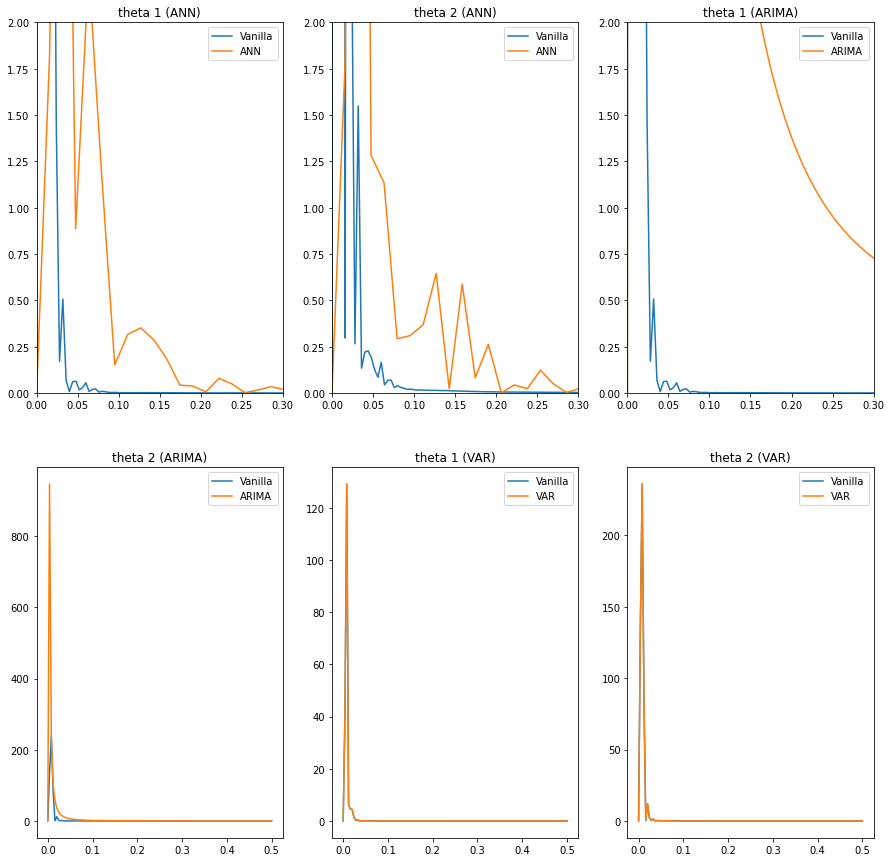

In [ ]:
""" Obtenemos las densidades espectrales """
lent_mitad = int(0.5*len(t))
# Theta 1 vanilla
f_datos1, P_datos1 = signal.periodogram(datos.values[lent_mitad:, 0], fs=1.0)
# Omega 1 vanilla
f_datos2, P_datos2 = signal.periodogram(datos.values[lent_mitad:, 1], fs=1.0)
# Theta 2 vanilla
f_datos3, P_datos3 = signal.periodogram(datos.values[lent_mitad:, 2], fs = 1.0)
# Omega 2 vanilla
f_datos4, P_datos4 = signal.periodogram(datos.values[lent_mitad:, 3], fs=1.0)


# Theta 1 con la prediccion ANN
f_ANN1, P_ANN1 = signal.periodogram(datos_ANN.values[lent_mitad:, 0], fs = 4.0)
# Omega 1 con la prediccion ANN
f_ANN2, P_ANN2 = signal.periodogram(datos_ANN.values[lent_mitad:, 1], fs=1.0)
# Theta 2 con la prediccion ANN
f_ANN3, P_ANN3 = signal.periodogram(datos_ANN.values[lent_mitad:, 2], fs = 4.0)
# Omega 2 con la prediccion ANN
f_ANN4, P_ANN4 = signal.periodogram(datos_ANN.values[lent_mitad:, 3], fs=1.0)


# Theta 1 con la prediccion VAR
f_var1, P_var1 = signal.periodogram(datos_var.values[lent_mitad:, 0], fs = 1.0)
# Omega 1 con la prediccion VAR
f_var2, P_var2 = signal.periodogram(datos_var.values[lent_mitad:, 1], fs=1.0)
# Theta 2 con la prediccion VAR
f_var3, P_var3 = signal.periodogram(datos_var.values[lent_mitad:, 2], fs = 1.0)
# Omega 2 con la prediccion VAR
f_var4, P_var4 = signal.periodogram(datos_var.values[lent_mitad:, 3], fs=1.0)


# Theta 1 con la prediccion ARIMA
f_arima1, P_arima1 = signal.periodogram(datos_arima.values[lent_mitad:, 0], fs = 1.0)
# Omega 1 con la prediccion ARIMA
f_arima2, P_arima2 = signal.periodogram(datos_arima.values[lent_mitad:, 1], fs=1.0)
# Theta 2 con la prediccion ARIMA
f_arima3, P_arima3 = signal.periodogram(datos_arima.values[lent_mitad:, 2], fs = 1.0)
# Omega 2 con la prediccion ARIMA
f_arima4, P_arima4 = signal.periodogram(datos_arima.values[lent_mitad:, 3], fs=1.0)


""" Ploteamos las series temporales de los angulos (las thetas) """
fig4 = plt.figure(figsize=(15, 15))
for i in range(6):
    ax4 = fig4.add_subplot(2, 3, i+1)
    ax4.set_title("Grafico #%i"%int(i+1))
fig4.subplots_adjust(wspace = 0.2, hspace = 0.2)

# Vanilla vs ANN 1
fig4.axes[0].plot(f_datos1, P_datos1, label = 'Vanilla')
fig4.axes[0].plot(f_ANN1, P_ANN1, label = 'ANN')
fig4.axes[0].set_title("theta 1 (ANN)")
fig4.axes[0].legend()
fig4.axes[0].set_ylim(0, 2)
fig4.axes[0].set_xlim(0, 0.3)

# Vanilla vs ANN 2
fig4.axes[1].plot(f_datos3, P_datos3, label = 'Vanilla')
fig4.axes[1].plot(f_ANN3, P_ANN3, label = 'ANN')
fig4.axes[1].set_title("theta 2 (ANN)")
fig4.axes[1].legend()
fig4.axes[1].set_ylim(0, 2)
fig4.axes[1].set_xlim(0, 0.3)

# Vanilla vs arima 1
fig4.axes[2].plot(f_datos1, P_datos1, label = 'Vanilla')
fig4.axes[2].plot(f_arima1, P_arima1, label = 'ARIMA')
fig4.axes[2].set_title("theta 1 (ARIMA)")
fig4.axes[2].legend()
fig4.axes[2].set_ylim(0, 2)
fig4.axes[2].set_xlim(0, 0.3)

# Vanilla vs arima 2
fig4.axes[3].plot(f_datos3, P_datos3, label = 'Vanilla')
fig4.axes[3].plot(f_arima3, P_arima3, label = 'ARIMA')
fig4.axes[3].set_title("theta 2 (ARIMA)")
fig4.axes[3].legend()
#fig4.axes[3].set_ylim(0, 2)
#fig4.axes[3].set_xlim(0, 0.3)

# Vanilla vs VAR 1
fig4.axes[4].plot(f_datos1, P_datos1, label = 'Vanilla')
fig4.axes[4].plot(f_var1, P_var1, label = 'VAR')
fig4.axes[4].set_title("theta 1 (VAR)")
fig4.axes[4].legend()
#fig4.axes[4].set_ylim(0, 2)
#fig4.axes[4].set_xlim(0, 0.3)

# Vanilla vs VAR 2
fig4.axes[5].plot(f_datos3, P_datos3, label = 'Vanilla')
fig4.axes[5].plot(f_var3, P_var3, label = 'VAR')
fig4.axes[5].set_title("theta 2 (VAR)")
fig4.axes[5].legend()
#fig4.axes[5].set_ylim(0, 2)
#fig4.axes[5].set_xlim(0, 0.3)

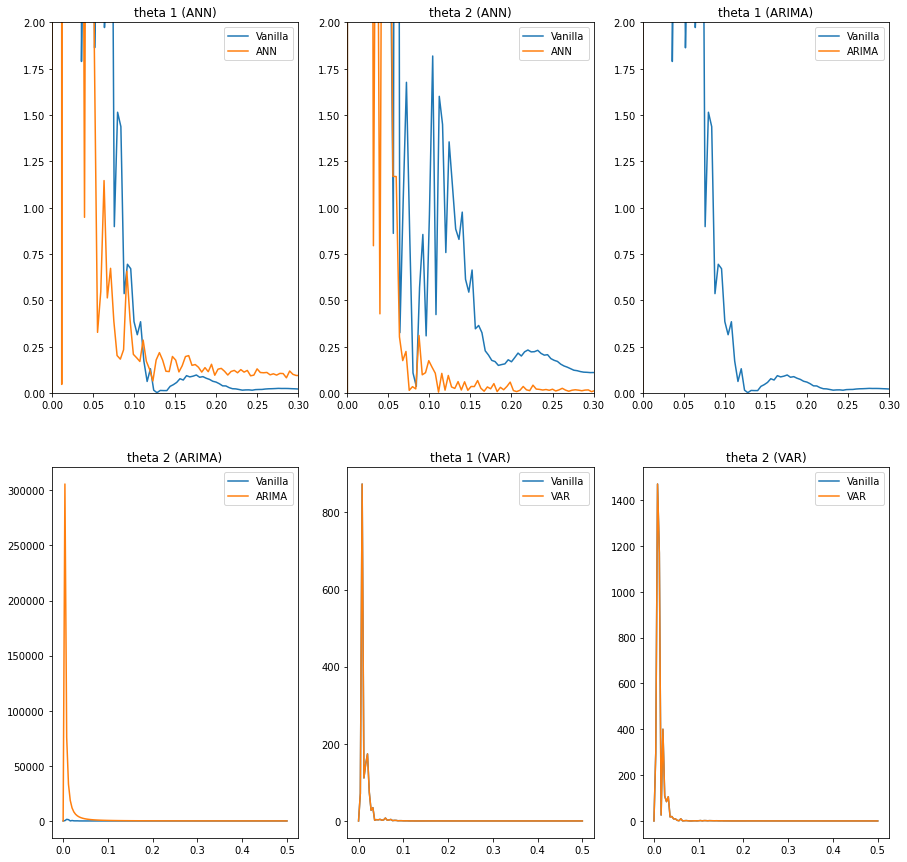

In [ ]:
""" Ploteamos las velocidades (las omegas) """
fig4 = plt.figure(figsize=(15, 15))
for i in range(6):
    ax4 = fig4.add_subplot(2, 3, i+1)
    ax4.set_title("Grafico #%i"%int(i+1))
fig4.subplots_adjust(wspace = 0.2, hspace = 0.2)

# Vanilla vs ANN 1
fig4.axes[0].plot(f_datos2, P_datos2, label = 'Vanilla')
fig4.axes[0].plot(f_ANN2, P_ANN2, label = 'ANN')
fig4.axes[0].set_title("theta 1 (ANN)")
fig4.axes[0].legend()
fig4.axes[0].set_ylim(0, 2)
fig4.axes[0].set_xlim(0, 0.3)

# Vanilla vs ANN 2
fig4.axes[1].plot(f_datos4, P_datos4, label = 'Vanilla')
fig4.axes[1].plot(f_ANN4, P_ANN4, label = 'ANN')
fig4.axes[1].set_title("theta 2 (ANN)")
fig4.axes[1].legend()
fig4.axes[1].set_ylim(0, 2)
fig4.axes[1].set_xlim(0, 0.3)

# Vanilla vs arima 1
fig4.axes[2].plot(f_datos2, P_datos2, label = 'Vanilla')
fig4.axes[2].plot(f_arima2, P_arima2, label = 'ARIMA')
fig4.axes[2].set_title("theta 1 (ARIMA)")
fig4.axes[2].legend()
fig4.axes[2].set_ylim(0, 2)
fig4.axes[2].set_xlim(0, 0.3)

# Vanilla vs arima 2
fig4.axes[3].plot(f_datos4, P_datos4, label = 'Vanilla')
fig4.axes[3].plot(f_arima4, P_arima4, label = 'ARIMA')
fig4.axes[3].set_title("theta 2 (ARIMA)")
fig4.axes[3].legend()
#fig4.axes[3].set_ylim(0, 2)
#fig4.axes[3].set_xlim(0, 0.3)

# Vanilla vs VAR 1
fig4.axes[4].plot(f_datos2, P_datos2, label = 'Vanilla')
fig4.axes[4].plot(f_var2, P_var2, label = 'VAR')
fig4.axes[4].set_title("theta 1 (VAR)")
fig4.axes[4].legend()
#fig4.axes[4].set_ylim(0, 2)
#fig4.axes[4].set_xlim(0, 0.3)

# Vanilla vs VAR 2
fig4.axes[5].plot(f_datos4, P_datos4, label = 'Vanilla')
fig4.axes[5].plot(f_var4, P_var4, label = 'VAR')
fig4.axes[5].set_title("theta 2 (VAR)")
fig4.axes[5].legend()
#fig4.axes[5].set_ylim(0, 2)
#fig4.axes[5].set_xlim(0, 0.3)


Sacamos los máximos espectrales para cada método de predicción, para así obtener los primeros períodos.

In [ ]:
# ARIMA
Tmax_arima1 = T_maximas(P_arima1, f_arima1)
Tmax_arima2 = T_maximas(P_arima2, f_arima2)

# VAR
Tmax_var1 = T_maximas(P_var1, f_var1)
Tmax_var2 = T_maximas(P_var2, f_var2)

# True
Tmax_true1 = T_maximas(P_datos1, f_datos1)
Tmax_true2 = T_maximas(P_datos2, f_datos2)

# ANN
Tmax_ANN1 = T_maximas(P_ANN1, f_ANN1)
Tmax_ANN2 = T_maximas(P_ANN2, f_ANN2)

print("ARIMA1: " + str(Tmax_arima1) + "\n"
+ "ARIMA2: " + str(Tmax_arima2) + "\n" + "\n"
+ "VAR1: " + str(Tmax_var1) + "\n" + "\n"
+ "VAR2: " + str(Tmax_var2) + "\n" + "\n"
+ "ANN1: " + str(Tmax_ANN1) + "\n" + "\n"
+ "ANN2: " + str(Tmax_ANN2) + "\n" + "\n"
+ "True1: " + str(Tmax_true1) + "\n" + "\n"
+ "True2: " + str(Tmax_true2) + "\n")

ARIMA1: [[252.]]
ARIMA2: [[252.]]

VAR1: [[125.          20.83333333  16.66666667  13.88888889   9.25925926
    7.35294118]]

VAR2: [[125.          50.          20.83333333  16.66666667  13.88888889
    6.09756098   5.68181818   3.62318841   2.63157895   2.01612903]]

ANN1: [[31.5         7.875       4.5         3.5         3.          2.33333333
   2.1         1.85294118  1.575       1.34042553  1.21153846  1.10526316
   1.          0.8630137   0.80769231  0.73255814  0.70786517  0.64285714
   0.6         0.57798165  0.55263158  0.525       0.504     ]]

ANN2: [[126.          21.          15.75        10.95652174   9.
    7.63636364   6.81081081   6.           5.14285714   4.84615385
    4.34482759   4.           3.81818182   3.6          3.45205479
    3.18987342   3.07317073   2.93023256   2.68085106   2.47058824
    2.37735849   2.29090909   2.13559322   2.04878049]]

True1: [[125.          20.83333333  16.66666667  13.88888889   9.25925926
    7.35294118]]

True2: [[125.          

#### 4.2. Obtención de la densidad espectral mediante el método Welch.

/usr/local/lib/python3.7/dist-packages/scipy/signal/spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 250, using nperseg = 250
  .format(nperseg, input_length))
/usr/local/lib/python3.7/dist-packages/scipy/signal/spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 252, using nperseg = 252
  .format(nperseg, input_length))


(0.0, 0.3)

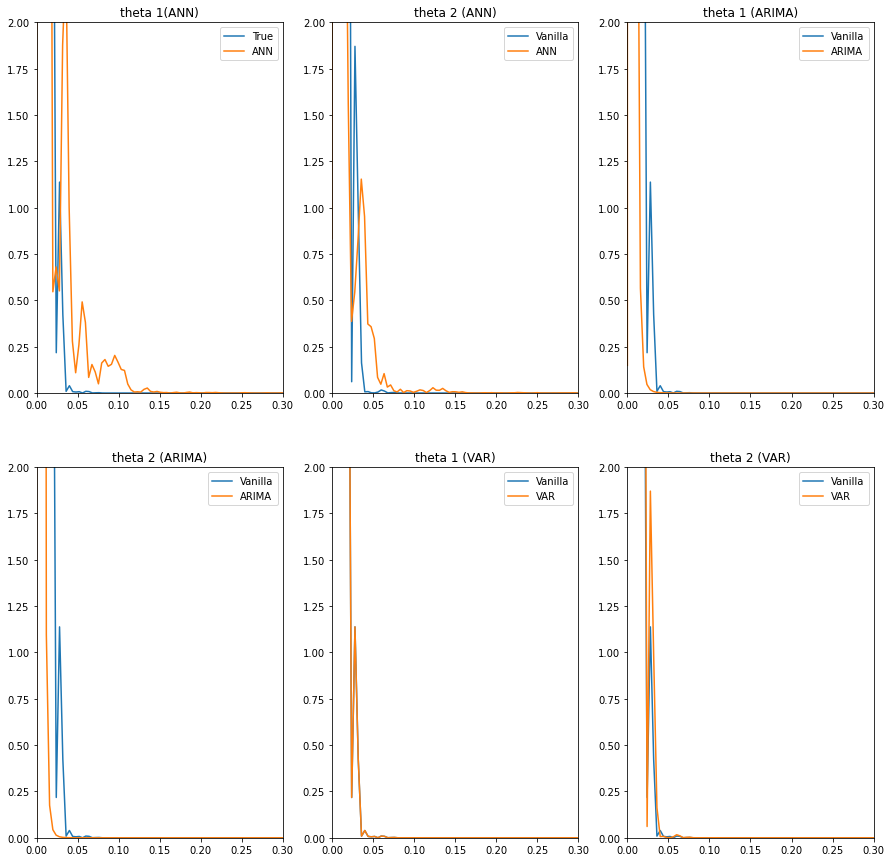

In [ ]:
""" Obtenemos las densidades espectrales """

# Theta 1 vanilla
fw_datos1, Pw_datos1 = signal.welch(datos.values[lent_mitad:, 0], fs = 1.0)
# Omega 1 vanilla
fw_datos2, Pw_datos2 = signal.welch(datos.values[lent_mitad:, 1], fs = 1.0)
# Theta 2 vanilla
fw_datos3, Pw_datos3 = signal.welch(datos.values[lent_mitad:, 2], fs = 1.0)
# Omega 2 vanilla
fw_datos4, Pw_datos4 = signal.welch(datos.values[lent_mitad:, 3], fs = 1.0)


# Theta 1 ANN
fw_ANN1, Pw_ANN1 = signal.welch(datos_ANN.values[lent_mitad:, 0], fs = 1.0)
# Omega 1 ANN
fw_ANN2, Pw_ANN2 = signal.welch(datos_ANN.values[lent_mitad:, 1], fs = 1.0)
# Theta 2 ANN
fw_ANN3, Pw_ANN3 = signal.welch(datos_ANN.values[lent_mitad:, 2], fs = 1.0)
# Omega 2 ANN
fw_ANN4, Pw_ANN4 = signal.welch(datos_ANN.values[lent_mitad:, 3], fs = 1.0)


# Theta 1 VAR
fw_var1, Pw_var1 = signal.welch(datos_var.values[lent_mitad:, 0], fs = 1.0)
# Omega 1 VAR
fw_var2, Pw_var2 = signal.welch(datos_var.values[lent_mitad:, 1], fs = 1.0)
# Theta 2 VAR
fw_var3, Pw_var3 = signal.welch(datos_var.values[lent_mitad:, 2], fs = 1.0)
# Omega 2 VAR
fw_var4, Pw_var4 = signal.welch(datos_var.values[lent_mitad:, 3], fs = 1.0)



# Theta 1 ARIMA
fw_arima1, Pw_arima1 = signal.welch(datos_arima.values[lent_mitad:, 0], fs = 1.0)
# Omega 1 ARIMA
fw_arima2, Pw_arima2 = signal.welch(datos_arima.values[lent_mitad:, 1], fs = 1.0)
# Theta 2 ARIMA
fw_arima3, Pw_arima3 = signal.welch(datos_arima.values[lent_mitad:, 2], fs = 1.0)
# Omega 2 ARIMA
fw_arima4, Pw_arima4 = signal.welch(datos_arima.values[lent_mitad:, 3], fs = 1.0)


""" Ploteamos los angulos (las thetas) """
fig5 = plt.figure(figsize=(15, 15))
for i in range(6):
    ax5 = fig5.add_subplot(2, 3, i+1)
    ax5.set_title("Grafico #%i"%int(i+1))
# Vanilla vs ANN 1
fig5.axes[0].plot(fw_datos1, Pw_datos1, label = 'True')
fig5.axes[0].plot(fw_ANN1, Pw_ANN1, label = 'ANN')
fig5.axes[0].set_title("theta 1(ANN)")
fig5.axes[0].legend()
fig5.axes[0].set_ylim(0, 2)
fig5.axes[0].set_xlim(0, 0.3)

# Vanilla vs ANN 2
fig5.axes[1].plot(fw_datos3, Pw_datos3, label = 'Vanilla')
fig5.axes[1].plot(fw_ANN3, Pw_ANN3, label = 'ANN')
fig5.axes[1].set_title("theta 2 (ANN)")
fig5.axes[1].legend()
fig5.axes[1].set_ylim(0, 2)
fig5.axes[1].set_xlim(0, 0.3)

# Vanilla vs arima 1
fig5.axes[2].plot(fw_datos1, Pw_datos1, label = 'Vanilla')
fig5.axes[2].plot(fw_arima1, Pw_arima1, label = 'ARIMA')
fig5.axes[2].set_title("theta 1 (ARIMA)")
fig5.axes[2].legend()
fig5.axes[2].set_ylim(0, 2)
fig5.axes[2].set_xlim(0, 0.3)

# Vanilla vs arima 2
fig5.axes[3].plot(fw_datos1, Pw_datos1, label = 'Vanilla')
fig5.axes[3].plot(fw_arima3, Pw_arima3, label = 'ARIMA')
fig5.axes[3].set_title("theta 2 (ARIMA)")
fig5.axes[3].legend()
fig5.axes[3].set_ylim(0, 2)
fig5.axes[3].set_xlim(0, 0.3)

# Vanilla vs VAR 1
fig5.axes[4].plot(fw_datos1, Pw_datos1, label = 'Vanilla')
fig5.axes[4].plot(fw_var1, Pw_var1, label = 'VAR')
fig5.axes[4].set_title("theta 1 (VAR)")
fig5.axes[4].legend()
fig5.axes[4].set_ylim(0, 2)
fig5.axes[4].set_xlim(0, 0.3)

# Vanilla vs VAR 2
fig5.axes[5].plot(fw_datos1, Pw_datos1, label = 'Vanilla')
fig5.axes[5].plot(fw_var3, Pw_var3, label = 'VAR')
fig5.axes[5].set_title("theta 2 (VAR)")
fig5.axes[5].legend()
fig5.axes[5].set_ylim(0, 2)
fig5.axes[5].set_xlim(0, 0.3)


(0.0, 0.3)

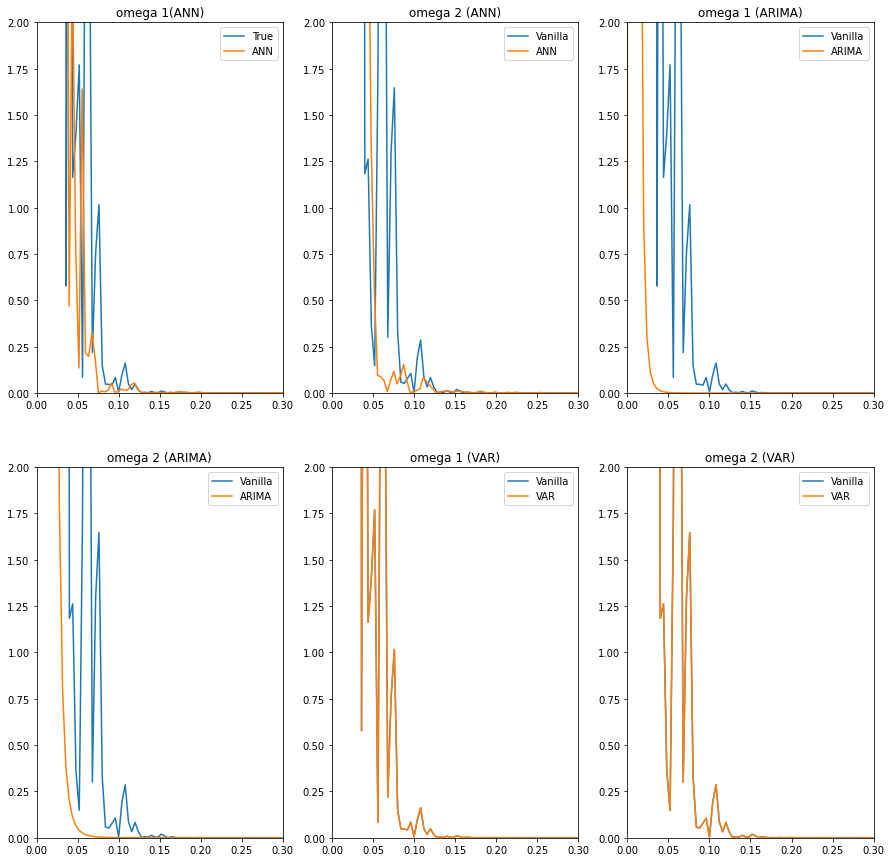

In [ ]:
""" Ploteamos las velocidades(las omegas) """
fig5_vel = plt.figure(figsize=(15, 15))
for i in range(6):
    ax5_vel = fig5_vel.add_subplot(2, 3, i+1)
    ax5_vel.set_title("Grafico #%i"%int(i+1))

# Vanilla vs ANN 1
fig5_vel.axes[0].plot(fw_datos2, Pw_datos2, label = 'True')
fig5_vel.axes[0].plot(fw_ANN2, Pw_ANN2, label = 'ANN')
fig5_vel.axes[0].set_title("omega 1(ANN)")
fig5_vel.axes[0].legend()
fig5_vel.axes[0].set_ylim(0, 2)
fig5_vel.axes[0].set_xlim(0, 0.3)

# Vanilla vs ANN 2
fig5_vel.axes[1].plot(fw_datos4, Pw_datos4, label = 'Vanilla')
fig5_vel.axes[1].plot(fw_ANN4, Pw_ANN4, label = 'ANN')
fig5_vel.axes[1].set_title("omega 2 (ANN)")
fig5_vel.axes[1].legend()
fig5_vel.axes[1].set_ylim(0, 2)
fig5_vel.axes[1].set_xlim(0, 0.3)

# Vanilla vs arima 1
fig5_vel.axes[2].plot(fw_datos2, Pw_datos2, label = 'Vanilla')
fig5_vel.axes[2].plot(fw_arima2, Pw_arima2, label = 'ARIMA')
fig5_vel.axes[2].set_title("omega 1 (ARIMA)")
fig5_vel.axes[2].legend()
fig5_vel.axes[2].set_ylim(0, 2)
fig5_vel.axes[2].set_xlim(0, 0.3)

# Vanilla vs arima 2
fig5_vel.axes[3].plot(fw_datos4, Pw_datos4, label = 'Vanilla')
fig5_vel.axes[3].plot(fw_arima4, Pw_arima4, label = 'ARIMA')
fig5_vel.axes[3].set_title("omega 2 (ARIMA)")
fig5_vel.axes[3].legend()
fig5_vel.axes[3].set_ylim(0, 2)
fig5_vel.axes[3].set_xlim(0, 0.3)

# Vanilla vs VAR 1
fig5_vel.axes[4].plot(fw_datos2, Pw_datos2, label = 'Vanilla')
fig5_vel.axes[4].plot(fw_var2, Pw_var2, label = 'VAR')
fig5_vel.axes[4].set_title("omega 1 (VAR)")
fig5_vel.axes[4].legend()
fig5_vel.axes[4].set_ylim(0, 2)
fig5_vel.axes[4].set_xlim(0, 0.3)

# Vanilla vs VAR 2
fig5_vel.axes[5].plot(fw_datos4, Pw_datos4, label = 'Vanilla')
fig5_vel.axes[5].plot(fw_var4, Pw_var4, label = 'VAR')
fig5_vel.axes[5].set_title("omega 2 (VAR)")
fig5_vel.axes[5].legend()
fig5_vel.axes[5].set_ylim(0, 2)
fig5_vel.axes[5].set_xlim(0, 0.3)


Como se ha hecho antes, obtenemos los máximos de cada método de predicción.

In [ ]:
# ARIMA
Tmax_arima1w = T_maximas(Pw_arima1, fw_arima1)
Tmax_arima2w = T_maximas(Pw_arima2, fw_arima2)

# VAR
Tmax_var1w = T_maximas(Pw_var1, fw_var1)
Tmax_var2w = T_maximas(Pw_var2, fw_var2)

# True
Tmax_true1w = T_maximas(Pw_datos1, fw_datos1)
Tmax_true2w = T_maximas(Pw_datos2, fw_datos2)

# ANN
Tmax_ANN1w = T_maximas(Pw_ANN1, fw_ANN1)
Tmax_ANN2w = T_maximas(Pw_ANN2, fw_ANN2)

print("ARIMA1: " + str(Tmax_arima1w) + "\n"
+ "ARIMA2: " + str(Tmax_arima2w) + "\n" + "\n"
+ "VAR1: " + str(Tmax_var1w) + "\n" + "\n"
+ "VAR2: " + str(Tmax_var2w) + "\n" + "\n"
+ "ANN1: " + str(Tmax_ANN1w) + "\n" + "\n"
+ "ANN2: " + str(Tmax_ANN2w) + "\n" + "\n"
+ "True1: " + str(Tmax_true1w) + "\n" + "\n"
+ "True2: " + str(Tmax_true2w) + "\n")

### 5. Representación del espacio de fases 
Vamos a representar el espacio de las fases, esto es $\theta_1 - \omega_1$, $\theta_2 - \omega_2$.

#### 5.1. Representación de $\theta_1 - \omega_1$ y de $\theta_2 - \omega_2$

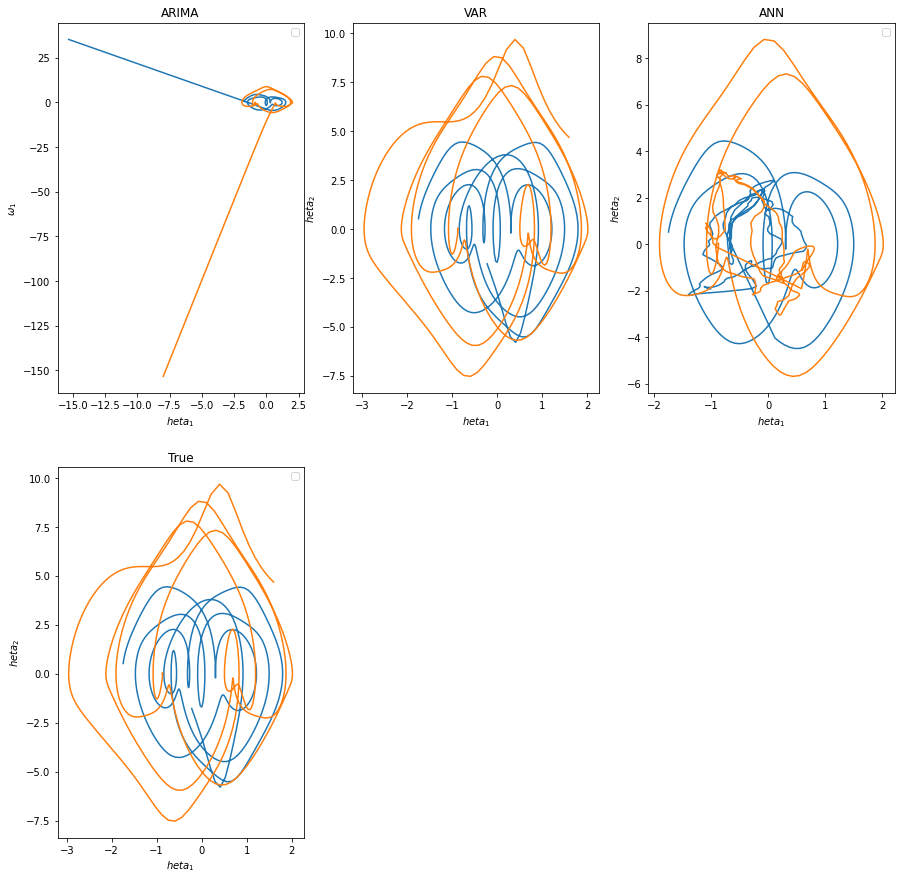

In [ ]:
fig6 = plt.figure(figsize=(15, 15))
for i in range(4):
    ax6 = fig6.add_subplot(2, 3, i+1)
    ax6.set_title("Grafico #%i"%int(i+1))
fig6.subplots_adjust(wspace = 0.2, hspace = 0.2)

# ARIMA
fig6.axes[0].plot(datos_arima.values[:, 0], datos_arima.values[:, 1], label = "1")
fig6.axes[0].plot(datos_arima.values[:, 2], datos_arima.values[:, 3], label = "2")
fig6.axes[0].set_title("ARIMA")
fig6.axes[0].set_ylabel("$\omega_1$")
fig6.axes[0].set_xlabel("$\theta_1$")
fig6.axes[0].legend()

# VAR
fig6.axes[1].plot(datos_var.values[:, 0], datos_var.values[:, 1], label = "1")
fig6.axes[1].plot(datos_var.values[:, 2], datos_var.values[:, 3], label = "2")
fig6.axes[1].set_title("VAR")
fig6.axes[1].set_xlabel("$\theta_1$")
fig6.axes[1].set_ylabel("$\theta_2$")

# ANN
fig6.axes[2].plot(datos_ANN.values[:, 0], datos_ANN.values[:, 1], label = "1")
fig6.axes[2].plot(datos_ANN.values[:, 2], datos_ANN.values[:, 3], label = "2")
fig6.axes[2].set_xlabel("$\theta_1$")
fig6.axes[2].set_ylabel("$\theta_2$")
fig6.axes[2].set_title("ANN")
fig6.axes[2].legend()

# Truth
fig6.axes[3].plot(datos.values[:, 0], datos.values[:, 1], label = "1")
fig6.axes[3].plot(datos.values[:, 2], datos.values[:, 3], label = "2")
fig6.axes[3].set_xlabel("$\theta_1$")
fig6.axes[3].set_ylabel("$\theta_2$")
fig6.axes[3].set_title("True")
fig6.axes[3].legend()

### 6. Representación del espacio de configuración

Este es, básicamente, $\theta1 - \theta2$, para cada método de predicción.

In [ ]:
fig7 = plt.figure(figsize=(15, 15))
for i in range(4):
    ax7 = fig7.add_subplot(2, 3, i+1)
    ax7.set_title("Grafico #%i"%int(i+1))
fig7.subplots_adjust(wspace = 0.2, hspace = 0.2)

# ARIMA
fig7.axes[0].plot(datos_arima.values[:, 0], datos_arima.values[:, 2])
fig7.axes[0].set_title("ARIMA")
fig7.axes[0].set_ylabel("$\theta_2$")
fig7.axes[0].set_xlabel("$\theta_1$")
fig7.axes[0].legend()

# VAR (siempre multistep)
fig7.axes[1].plot(datos_var.values[:, 0], datos_var.values[:, 2])
fig7.axes[1].set_title("VAR")
fig7.axes[1].set_xlabel("$\theta_1$")
fig7.axes[1].set_ylabel("$\theta_2$")

# ANN (multistep)
fig7.axes[2].plot(datos_ANN.values[:, 0], datos_ANN.values[:, 2])
fig7.axes[2].set_xlabel("$\theta_1$")
fig7.axes[2].set_ylabel("$\theta_2$")
fig7.axes[2].set_title("ANN")
fig7.axes[2].legend()

# Truth
fig7.axes[3].plot(datos.values[:, 0], datos.values[:, 2])
fig7.axes[3].set_xlabel("$\theta_1$")
fig7.axes[3].set_ylabel("$\theta_2$")
fig7.axes[3].set_title("True")
fig7.axes[3].legend()

 Vamos a representar también $\omega_1 - \omega_2$ para cada método de predicción.

In [ ]:
fig72 = plt.figure(figsize=(15, 15))
for i in range(4):
    ax72 = fig72.add_subplot(2, 3, i+1)
    ax72.set_title("Grafico #%i"%int(i+1))
fig72.subplots_adjust(wspace = 0.2, hspace = 0.2)

# ARIMA
fig72.axes[0].plot(datos_arima.values[:, 1], datos_arima.values[:, 3])
fig72.axes[0].set_title("ARIMA")
fig72.axes[0].set_ylabel("$\theta_2$")
fig72.axes[0].set_xlabel("$\theta_1$")
fig72.axes[0].legend()

# VAR
fig72.axes[1].plot(datos_var.values[:, 1], datos_var.values[:, 3])
fig72.axes[1].set_title("VAR")
fig72.axes[1].set_xlabel("$\theta_1$")
fig72.axes[1].set_ylabel("$\theta_2$")

# ANN
fig72.axes[2].plot(datos_ANN.values[:, 1], datos_ANN.values[:, 3])
fig72.axes[2].set_xlabel("$\theta_1$")
fig72.axes[2].set_ylabel("$\theta_2$")
fig72.axes[2].set_title("ANN")
fig72.axes[2].legend()

# Truth
fig72.axes[3].plot(datos.values[:, 1], datos.values[:, 3])
fig72.axes[3].set_xlabel("$\theta_1$")
fig72.axes[3].set_ylabel("$\theta_2$")
fig72.axes[3].set_title("True")
fig72.axes[3].legend()

### 7. Gráfica de las medias móviles y la autocovarianza

#### 7.1. Media móvil

In [ ]:
""" Ploteamos la de los ángulos, las thetas """
fig11 = plt.figure(figsize=(15, 15))
for i in range(4):
    ax11 = fig11.add_subplot(2, 3, i+1)
    ax11.set_title("Grafico #%i"%int(i+1))
fig11.subplots_adjust(wspace = 0.2, hspace = 0.2)


# ARIMA
fig11.axes[0].plot(t, datos_arima['x1(Ang1)'].rolling(window = 10).mean()[:len(t)], label = "theta1")
fig11.axes[0].plot(t, datos_arima['x3(Ang2)'].rolling(window = 10).mean()[:len(t)], label = "theta2")
fig11.axes[0].set_title("ARIMA Univariante")
fig11.axes[0].set_ylabel("Media movil")
fig11.axes[0].set_xlabel("Tiempo(s)")
fig11.axes[0].legend()

# VAR (siempre multistep)
fig11.axes[1].plot(t, datos_var['x1(Ang1)'].rolling(window = 10).mean()[:len(t)], label = "theta1")
fig11.axes[1].plot(t, datos_var['x3(Ang2)'].rolling(window = 10).mean()[:len(t)], label = "theta2")
fig11.axes[1].set_title("VAR multistep")
fig11.axes[1].set_xlabel("Tiempo(s)")
fig11.axes[1].set_ylabel("Media movil")

# ANN (multistep)
fig11.axes[2].plot(t, datos_ANN['x1(Ang1)'].rolling(window = 10).mean()[:len(t)], label = "theta1")
fig11.axes[2].plot(t, datos_ANN['x3(Ang2)'].rolling(window = 10).mean()[:len(t)], label = "theta2")
fig11.axes[2].set_xlabel("Tiempo(s)")
fig11.axes[2].set_ylabel("Media movil")
fig11.axes[2].set_title("ANN multistep")
fig11.axes[2].legend()

# Truth
fig11.axes[3].plot(t, datos['x1(Ang1)'].rolling(window = 10).mean()[:len(t)], label = "theta1")
fig11.axes[3].plot(t, datos['x3(Ang2)'].rolling(window = 10).mean()[:len(t)], label = "theta2")
fig11.axes[3].set_xlabel("Tiempo(s)")
fig11.axes[3].set_ylabel("Media movil")
fig11.axes[3].set_title("Truth")
fig11.axes[3].legend()

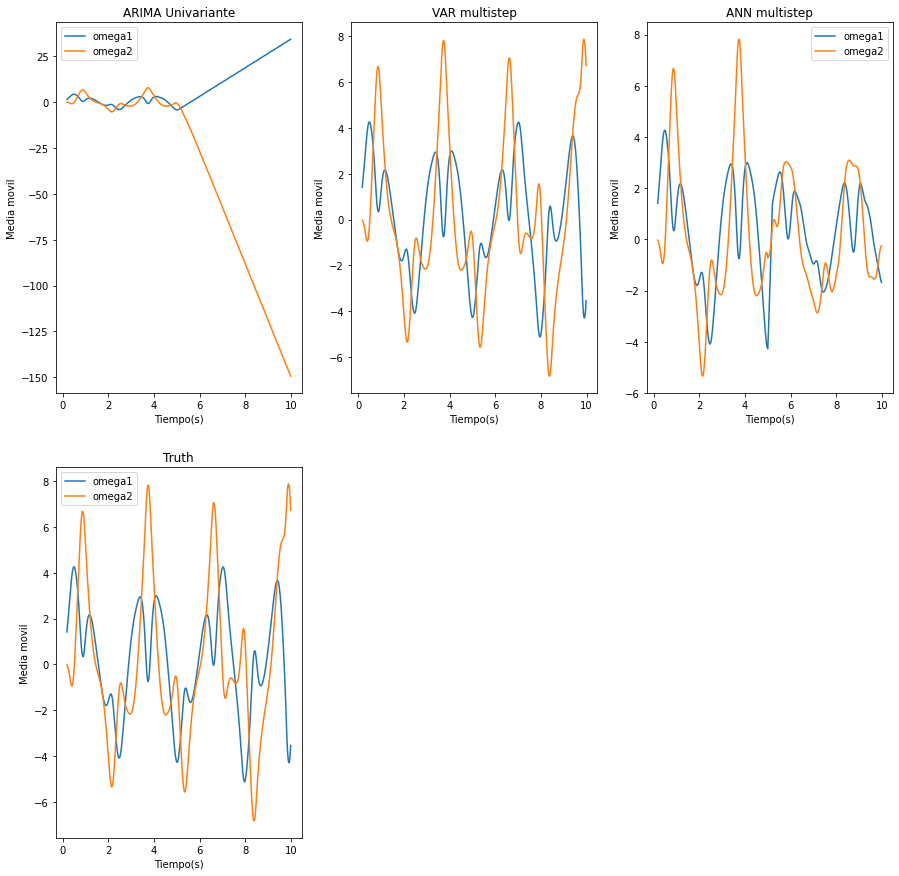

In [ ]:
""" Ploteamos las velocidades, las omegas """
fig11_vel = plt.figure(figsize=(15, 15))
for i in range(4):
    ax11_vel = fig11_vel.add_subplot(2, 3, i+1)
    ax11_vel.set_title("Grafico #%i"%int(i+1))
fig11_vel.subplots_adjust(wspace = 0.2, hspace = 0.2)


# ARIMA
fig11_vel.axes[0].plot(t, datos_arima['x2(Vel1)'].rolling(window = 10).mean()[:len(t)], label = "omega1")
fig11_vel.axes[0].plot(t, datos_arima['x4(Vel2)'].rolling(window = 10).mean()[:len(t)], label = "omega2")
fig11_vel.axes[0].set_title("ARIMA Univariante")
fig11_vel.axes[0].set_ylabel("Media movil")
fig11_vel.axes[0].set_xlabel("Tiempo(s)")
fig11_vel.axes[0].legend()

# VAR (siempre multistep)
fig11_vel.axes[1].plot(t, datos_var['x2(Vel1)'].rolling(window = 10).mean()[:len(t)], label = "omega1")
fig11_vel.axes[1].plot(t, datos_var['x4(Vel2)'].rolling(window = 10).mean()[:len(t)], label = "omega2")
fig11_vel.axes[1].set_title("VAR multistep")
fig11_vel.axes[1].set_xlabel("Tiempo(s)")
fig11_vel.axes[1].set_ylabel("Media movil")

# ANN (multistep)
fig11_vel.axes[2].plot(t, datos_ANN['x2(Vel1)'].rolling(window = 10).mean()[:len(t)], label = "omega1")
fig11_vel.axes[2].plot(t, datos_ANN['x4(Vel2)'].rolling(window = 10).mean()[:len(t)], label = "omega2")
fig11_vel.axes[2].set_xlabel("Tiempo(s)")
fig11_vel.axes[2].set_ylabel("Media movil")
fig11_vel.axes[2].set_title("ANN multistep")
fig11_vel.axes[2].legend()

# Truth
fig11_vel.axes[3].plot(t, datos['x2(Vel1)'].rolling(window = 10).mean()[:len(t)], label = "omega1")
fig11_vel.axes[3].plot(t, datos['x4(Vel2)'].rolling(window = 10).mean()[:len(t)], label = "omega2")
fig11_vel.axes[3].set_xlabel("Tiempo(s)")
fig11_vel.axes[3].set_ylabel("Media movil")
fig11_vel.axes[3].set_title("Truth")
fig11_vel.axes[3].legend()

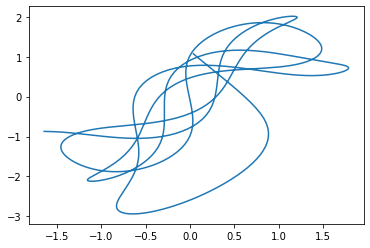

In [ ]:
plt.plot(datos['x1(Ang1)'].rolling(window = 10).mean(), datos['x3(Ang2)'].rolling(window = 10).mean())

#### 7.2. Autocovarianza

In [ ]:
""" Ploteamos para los ángulos, las thetas """
fig12 = plt.figure(figsize=(15, 15))
for i in range(4):
    ax12 = fig12.add_subplot(2, 3, i+1)
    ax12.set_title("Grafico #%i"%int(i+1))
fig12.subplots_adjust(wspace = 0.2, hspace = 0.2)

# ARIMA
fig12.axes[0].plot(t, smt.stattools.acovf(datos_arima.values[:, 0])[:len(t)], label = "theta1")
fig12.axes[0].plot(t, smt.stattools.acovf(datos_arima.values[:, 2])[:len(t)], label = "theta2")
fig12.axes[0].set_title("ARIMA Univariante")
fig12.axes[0].set_ylabel("Autocovarianza")
fig12.axes[0].set_xlabel("Tiempo(s)")
fig12.axes[0].legend()

# VAR (siempre multistep)
fig12.axes[1].plot(t, smt.stattools.acovf(datos_var.values[:, 0])[:len(t)], label = "theta1")
fig12.axes[1].plot(t, smt.stattools.acovf(datos_var.values[:, 2])[:len(t)], label = "theta2")
fig12.axes[1].set_title("VAR multistep")
fig12.axes[1].set_xlabel("Tiempo(s)")
fig12.axes[1].set_ylabel("Autocovarianza")

# ANN (multistep)
fig12.axes[2].plot(t, smt.stattools.acovf(datos_ANN.values[:, 0])[:len(t)], label = "theta1")
fig12.axes[2].plot(t, smt.stattools.acovf(datos_ANN.values[:, 2])[:len(t)], label = "theta2")
fig12.axes[2].set_xlabel("Tiempo(s)")
fig12.axes[2].set_ylabel("Autocovarianza")
fig12.axes[2].set_title("ANN multistep")
fig12.axes[2].legend()

# Truth
fig12.axes[3].plot(t, smt.stattools.acovf(datos.values[:, 0])[:len(t)], label = "theta1")
fig12.axes[3].plot(t, smt.stattools.acovf(datos.values[:, 2])[:len(t)], label = "theta2")
fig12.axes[3].set_xlabel("Tiempo(s)")
fig12.axes[3].set_ylabel("Autocovarianza")
fig12.axes[3].set_title("Truth")
fig12.axes[3].legend()


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:441: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:441: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:441: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:441: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly

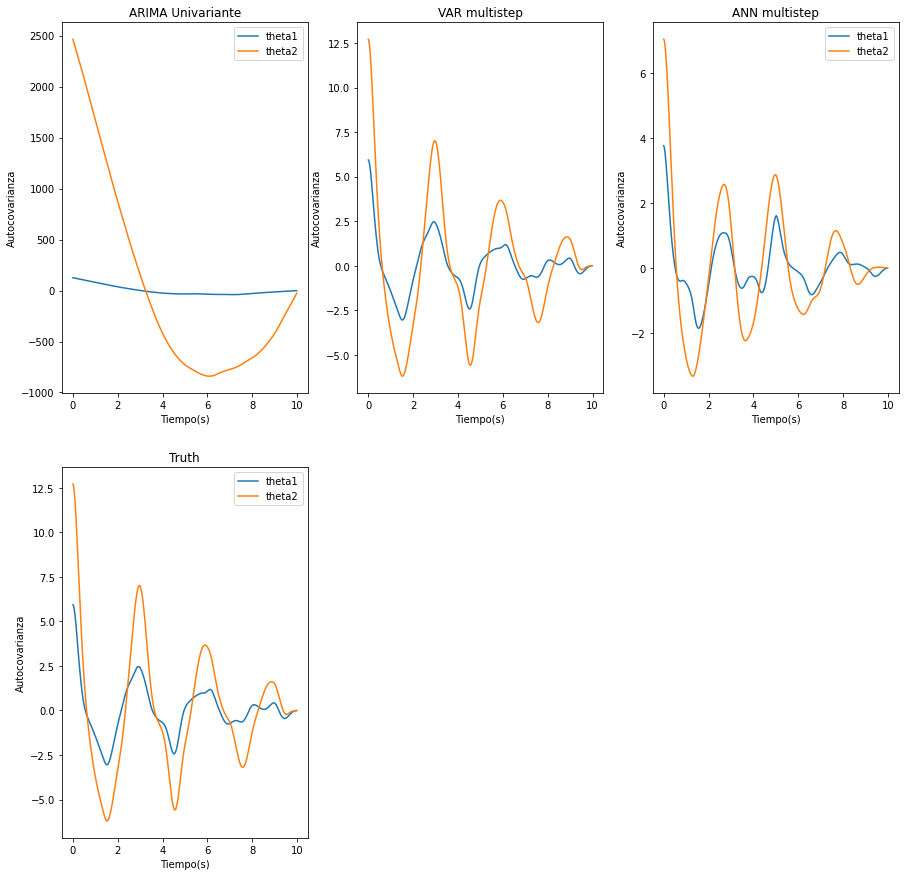

In [ ]:
""" Ploteamos para las velocidades """
fig12_vel = plt.figure(figsize=(15, 15))
for i in range(4):
    ax12_vel = fig12_vel.add_subplot(2, 3, i+1)
    ax12_vel.set_title("Grafico #%i"%int(i+1))
fig12_vel.subplots_adjust(wspace = 0.2, hspace = 0.2)

# ARIMA
fig12_vel.axes[0].plot(t, smt.stattools.acovf(datos_arima.values[:, 1])[:len(t)], label = "theta1")
fig12_vel.axes[0].plot(t, smt.stattools.acovf(datos_arima.values[:, 3])[:len(t)], label = "theta2")
fig12_vel.axes[0].set_title("ARIMA Univariante")
fig12_vel.axes[0].set_ylabel("Autocovarianza")
fig12_vel.axes[0].set_xlabel("Tiempo(s)")
fig12_vel.axes[0].legend()

# VAR (siempre multistep)
fig12_vel.axes[1].plot(t, smt.stattools.acovf(datos_var.values[:, 1])[:len(t)], label = "theta1")
fig12_vel.axes[1].plot(t, smt.stattools.acovf(datos_var.values[:, 3])[:len(t)], label = "theta2")
fig12_vel.axes[1].set_title("VAR multistep")
fig12_vel.axes[1].set_xlabel("Tiempo(s)")
fig12_vel.axes[1].set_ylabel("Autocovarianza")

# ANN (multistep)
fig12_vel.axes[2].plot(t, smt.stattools.acovf(datos_ANN.values[:, 1])[:len(t)], label = "theta1")
fig12_vel.axes[2].plot(t, smt.stattools.acovf(datos_ANN.values[:, 3])[:len(t)], label = "theta2")
fig12_vel.axes[2].set_xlabel("Tiempo(s)")
fig12_vel.axes[2].set_ylabel("Autocovarianza")
fig12_vel.axes[2].set_title("ANN multistep")
fig12_vel.axes[2].legend()

# Truth
fig12_vel.axes[3].plot(t, smt.stattools.acovf(datos.values[:, 1])[:len(t)], label = "theta1")
fig12_vel.axes[3].plot(t, smt.stattools.acovf(datos.values[:, 3])[:len(t)], label = "theta2")
fig12_vel.axes[3].set_xlabel("Tiempo(s)")
fig12_vel.axes[3].set_ylabel("Autocovarianza")
fig12_vel.axes[3].set_title("Truth")
fig12_vel.axes[3].legend()


### 8. Test de estacionariedad

#### 8.1. Serie real





In [ ]:
print("Test para la serie real")
for i in range(4):
  print("x" + str(i))
  print("\n")
  test_estacionariedad(datos.values[:, i])
  print("\n")

#### 8.2. ARIMA

In [ ]:
print("Test serie ARIMA")
for i in range(4):
  print("x" + str(i))
  print("\n")
  test_estacionariedad(datos_arima.values[:, i])
  print("\n")

#### 8.3. ANN

In [ ]:
print("Test serie ANN")
for i in range(4):
  print("x" + str(i))
  print("\n")
  test_estacionariedad(datos_ANN.values[:, i])
  print("\n")

#### 8.4. VAR

In [ ]:
print("Test serie VAR")
for i in range(4):
  print("x" + str(i))
  print("\n")
  test_estacionariedad(datos_var.values[:, i])
  print("\n")